<a href="https://colab.research.google.com/github/eduardova28/2025_UTEC_Programacion101/blob/main/TrabajoFinal_IA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# Imports the LSTM model and library
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [67]:
df = pd.read_excel("Inputs_Peru.xlsx")

In [68]:
df.head(8)

,Date,PP,Tmed,Flow
0,2010-01-01,0.0,10.725417,0.590622
1,2010-01-02,0.0,11.536250,0.575429
2,2010-01-03,0.0,12.087500,0.564597
3,2010-01-04,0.0,13.471250,0.554535
4,2010-01-05,0.1,11.676250,0.545122
5,2010-01-06,0.7,9.809167,0.536262
6,2010-01-07,0.1,11.902917,0.527877
7,2010-01-08,0.0,12.197083,0.519922


In [69]:
df.columns = df.columns.str.strip()
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5569 entries, 2010-01-01 to 2025-03-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5569 non-null   datetime64[ns]
 1   PP      5569 non-null   float64       
 2   Tmed    5547 non-null   float64       
 3   Flow    5569 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 217.5 KB


In [70]:
# Strip spaces from all column names
df.columns = df.columns.str.strip()

# Now you can use 'Date' without the space
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
df.set_index('Date', inplace=True)
df.head()

,PP,Tmed,Flow
Date,,,
2010-01-01,0.0,10.725417,0.590622
2010-01-02,0.0,11.536250,0.575429
2010-01-03,0.0,12.087500,0.564597
2010-01-04,0.0,13.471250,0.554535
2010-01-05,0.1,11.676250,0.545122


In [71]:
print(df.columns)

Index(['PP', 'Tmed', 'Flow'], dtype='object')


<Axes: xlabel='Date'>

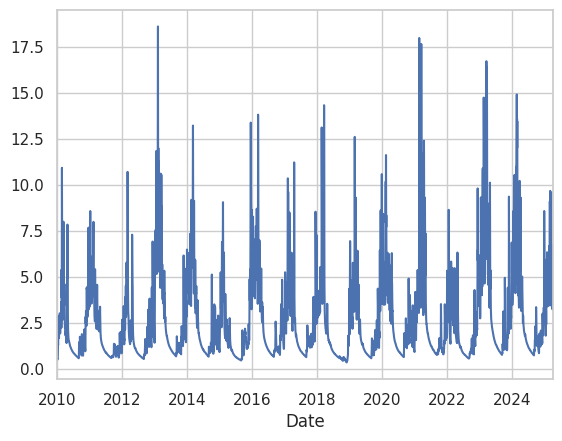

In [72]:
flow = df['Flow']
flow.plot()

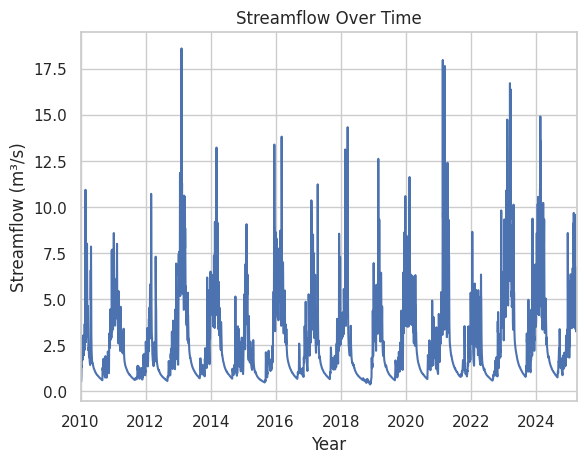

In [73]:
import matplotlib.pyplot as plt

flow = df['Flow']
flow.plot(xlabel='Year', ylabel='Streamflow (m³/s)', title='Streamflow Over Time')
plt.show()

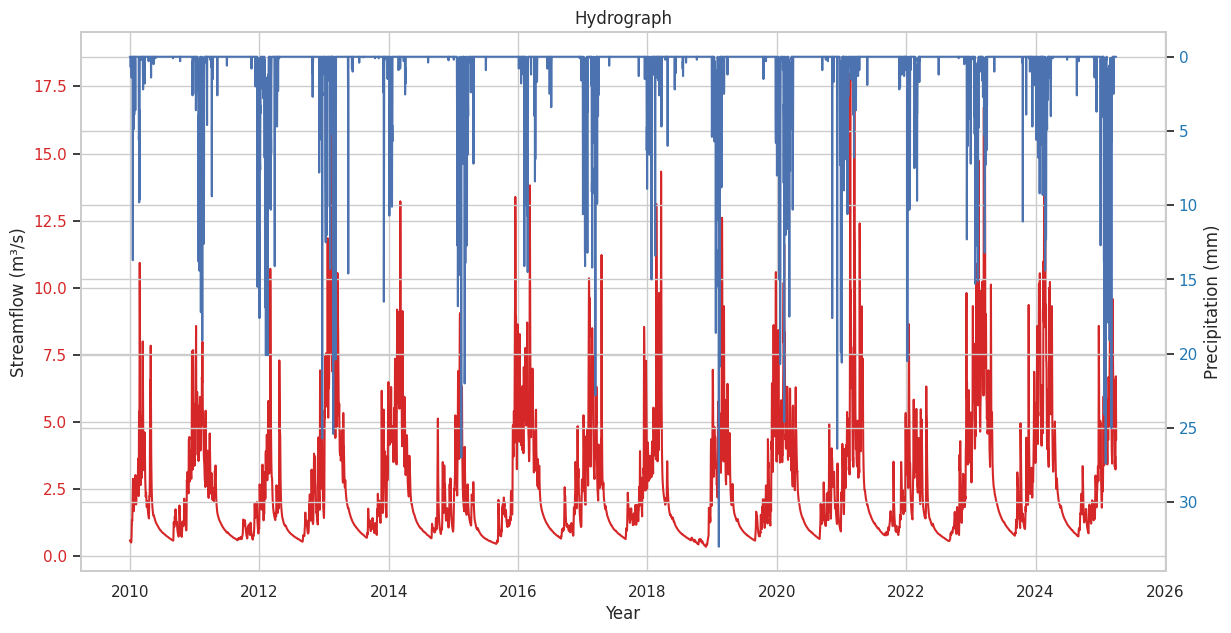

In [74]:
# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Precipitation on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Streamflow (m³/s)')
ax1.plot(df.index, df['Flow'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Streamflow
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year')
ax2.set_ylabel('Precipitation (mm)')
ax2.plot(df.index, df['PP'])
ax2.tick_params(axis='y', labelcolor=color)

# Invert the y-axis of ax2
ax2.invert_yaxis()

# Adding a title and a grid
#plt.title('Precipitation and Streamflow Over Time')
plt.title('Hydrograph')
plt.grid(True)

# Show the plot
plt.show()

Index(['PP', 'Tmed', 'Flow'], dtype='object')
count    5569.000000
mean        0.673568
std         2.548331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        33.000000
Name: PP, dtype: float64


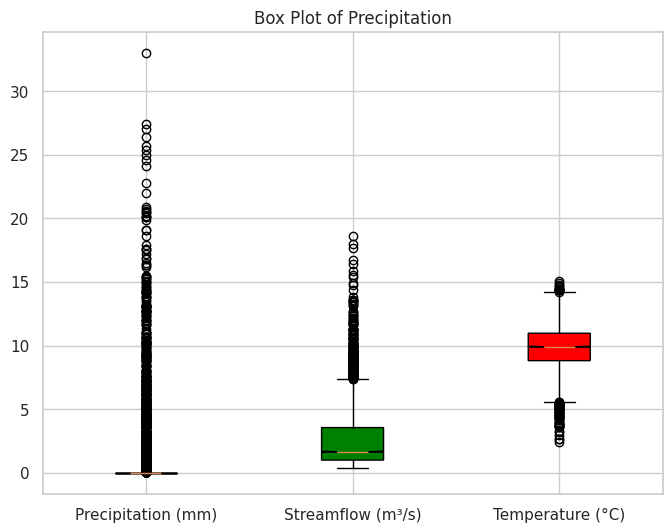

In [75]:
import matplotlib.pyplot as plt

print(df.columns)
print(df['PP'].describe())

data_to_plot = [
    df['PP'].dropna(),
    df['Flow'].dropna(),
    df['Tmed'].dropna()]

fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True)

colors = ['blue', 'green', 'red']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(['Precipitation (mm)', 'Streamflow (m³/s)', 'Temperature (°C)'])
plt.title('Box Plot of Precipitation')
plt.grid(True)
plt.show()

In [76]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [77]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(flow, WINDOW_SIZE)
X1.shape, y1.shape

((5564, 5, 1), (5564,))

In [78]:
X_train1, y_train1 = X1[:4018], y1[:4018]
X_val1, y_val1 = X1[4019:5114], y1[4019:5114]
X_test1, y_test1 = X1[5114:], y1[5114:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4018, 5, 1), (4018,), (1095, 5, 1), (1095,), (450, 5, 1), (450,))

In [79]:
os.makedirs("models", exist_ok=True)

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [81]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError()]
)
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
from tensorflow.keras.utils import plot_model

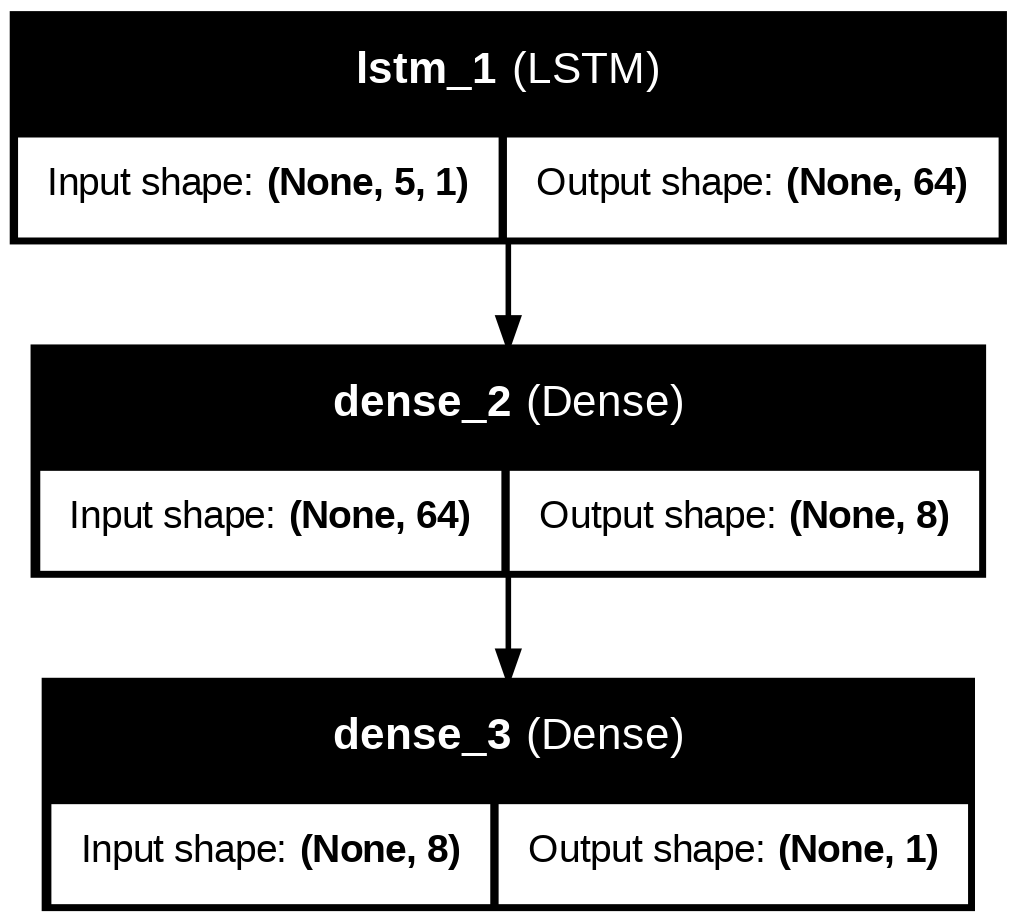

In [83]:
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [84]:
cp1 = ModelCheckpoint("models/model1.keras", save_best_only=False)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [85]:
history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=150, callbacks=[cp1])

Epoch 1/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.0823 - root_mean_squared_error: 3.0126 - val_loss: 11.0358 - val_root_mean_squared_error: 3.3220
Epoch 2/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5836 - root_mean_squared_error: 2.5615 - val_loss: 6.5922 - val_root_mean_squared_error: 2.5675
Epoch 3/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1195 - root_mean_squared_error: 1.7632 - val_loss: 4.1483 - val_root_mean_squared_error: 2.0367
Epoch 4/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0619 - root_mean_squared_error: 1.4325 - val_loss: 3.4561 - val_root_mean_squared_error: 1.8590
Epoch 5/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5861 - root_mean_squared_error: 1.2587 - val_loss: 3.0638 - val_root_mean_squared_error: 1.7504
Epoch 6/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4785 - root_mean_squared_error: 1.2149 - val_loss: 2.7828 - val_root_mean_squared_error: 1.6682
Epoch 7/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 

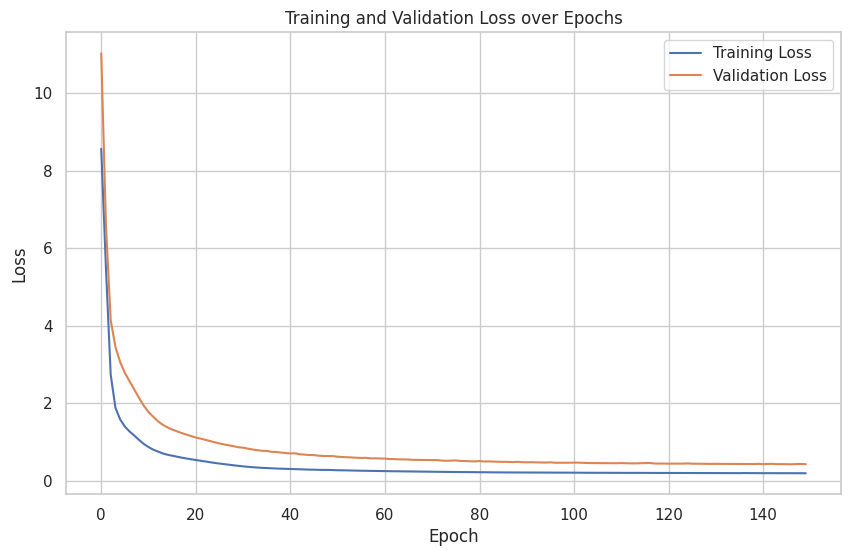

In [86]:
import matplotlib.pyplot as plt

# Access the history from the variable that stored the fit results
# Define the data
epochs = history.epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

In [88]:
from tensorflow.keras.models import load_model
model1 = load_model('models/model1.keras')

In [89]:
import math  # Import the math module to use its sqrt function

trainScore = model1.evaluate(X_train1, y_train1, verbose=0)
train_mse = trainScore[0]
train_rmse = trainScore[1]
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_mse, train_rmse))

testScore = model1.evaluate(X_test1, y_test1, verbose=0)
test_mse = testScore[0]
test_rmse = testScore[1]
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_mse, test_rmse))

Train Score: 0.19 MSE (0.44 RMSE)
Test Score: 0.39 MSE (0.63 RMSE)


In [90]:
model1 = load_model('models/model1.keras')

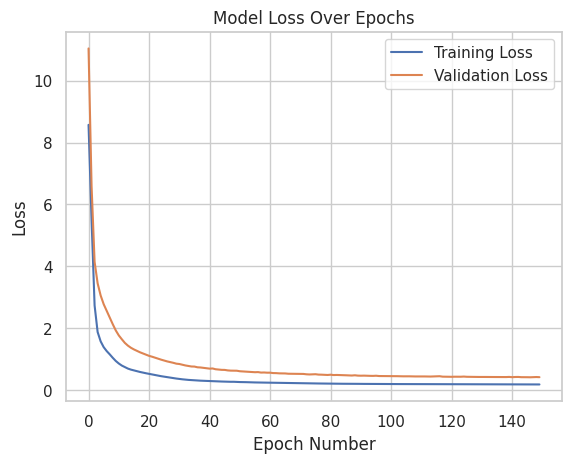

In [91]:
# Plot the model loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Train Predictions,Actuals
0,0.543130,0.536262
1,0.534187,0.527877
2,0.525833,0.519922
3,0.517917,0.512349
4,0.510366,0.607401
...,...,...
4013,1.971476,2.223926
4014,2.408543,2.119779
4015,1.987133,2.029673
4016,1.943702,2.824890


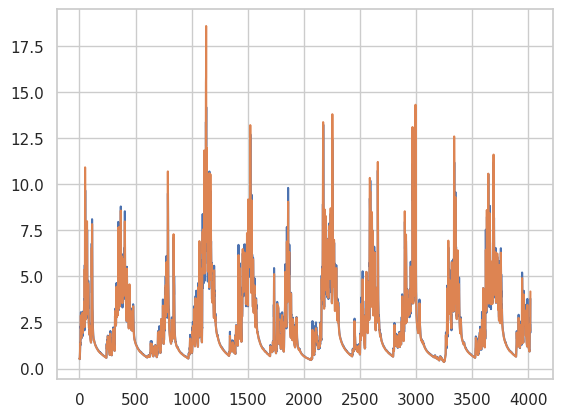

In [93]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][1:10000])
plt.plot(train_results['Actuals'][1:10000])

In [94]:
# Extract the dates that correspond to your training predictions
train_dates = df.index[WINDOW_SIZE:WINDOW_SIZE + len(train_predictions)]

# Create a DataFrame with predictions, actuals, and dates
train_results = pd.DataFrame({
    'Time': train_dates,
    'Train Predictions': train_predictions,
    'Actuals': y_train1
}).set_index('Time')

# Show the first few rows to verify
print(train_results.head(100))

            Train Predictions   Actuals
Time                                   
2010-01-06           0.543130  0.536262
2010-01-07           0.534187  0.527877
2010-01-08           0.525833  0.519922
2010-01-09           0.517917  0.512349
2010-01-10           0.510366  0.607401
...                       ...       ...
2010-04-11           1.870516  1.842800
2010-04-12           1.874535  1.749492
2010-04-13           1.687587  1.673906
2010-04-14           1.658158  1.611158
2010-04-15           1.611657  1.558568

[100 rows x 2 columns]


/tmp/ipython-input-95-1022244676.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True, labels=['Train Predictions', 'Actuals'])


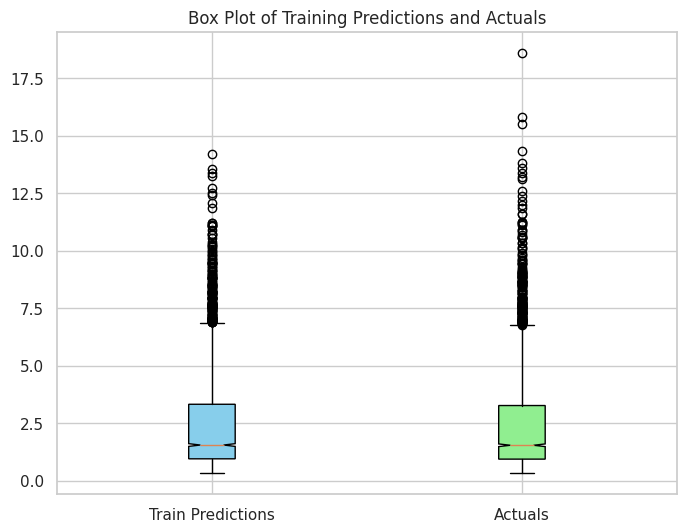

In [95]:
import matplotlib.pyplot as plt

# Assuming 'train_results' is already created and contains 'Train Predictions' and 'Actuals' columns
data_to_plot = [train_results['Train Predictions'], train_results['Actuals']]

# Create a figure instance and an axes instance
fig, ax = plt.subplots(figsize=(8, 6))

# Create the box plot
bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True, labels=['Train Predictions', 'Actuals'])

# Customizing colors for each box
colors = ['skyblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Adding a title and a grid
plt.title('Box Plot of Training Predictions and Actuals')
plt.grid(True)

# Show the plot
plt.show()

NaN in Train Predictions: 0
NaN in Actuals: 0

Five-number summary for Train Predictions:
count    4018.000000
mean        2.382764
std         1.999679
min         0.353569
25%         0.961346
50%         1.560370
75%         3.331899
max        14.196309
Name: Train Predictions, dtype: float64

Five-number summary for Actuals:
count    4018.000000
mean        2.391006
std         2.073739
min         0.353967
25%         0.947827
50%         1.550337
75%         3.276971
max        18.604452
Name: Actuals, dtype: float64


/tmp/ipython-input-96-838994878.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True, showfliers=True, labels=['Train Predictions', 'Observed'])


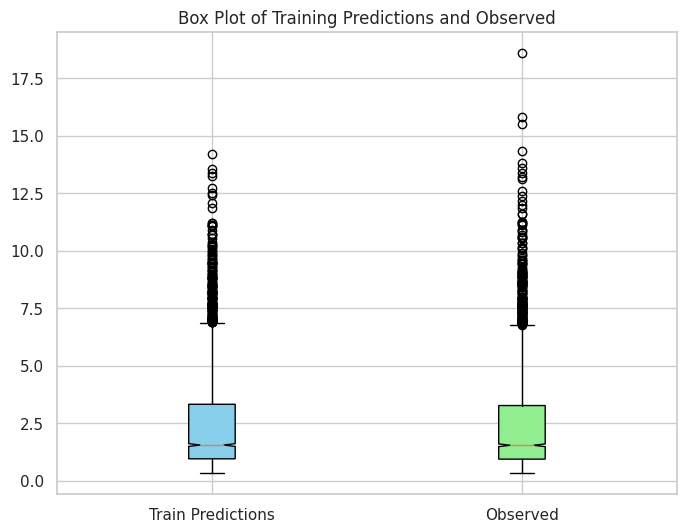

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'train_results' is your DataFrame
# Check for NaN values in your data
print("NaN in Train Predictions:", train_results['Train Predictions'].isna().sum())
print("NaN in Actuals:", train_results['Actuals'].isna().sum())

# Calculate and print the five-number summary for both predictions and actuals
print("\nFive-number summary for Train Predictions:")
print(train_results['Train Predictions'].describe())

print("\nFive-number summary for Actuals:")
print(train_results['Actuals'].describe())

# Create the box plot ensuring outliers are shown
fig, ax = plt.subplots(figsize=(8, 6))
data_to_plot = [train_results['Train Predictions'].dropna(), train_results['Actuals'].dropna()]
bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True, showfliers=True, labels=['Train Predictions', 'Observed'])

# Customizing colors for each box
colors = ['skyblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Adding a title and a grid
plt.title('Box Plot of Training Predictions and Observed')
plt.grid(True)

# Show the plot
plt.show()


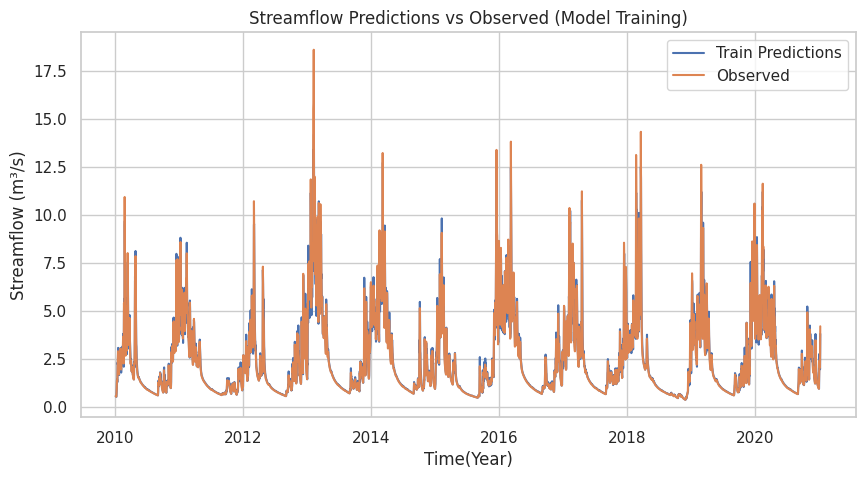

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_results['Train Predictions'], label='Train Predictions')
plt.plot(train_results['Actuals'], label='Observed')
plt.title('Streamflow Predictions vs Observed (Model Training)')
plt.xlabel('Time(Year)')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.show()

In [98]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define evaluation functions
def calculate_nse(actuals, predictions):
    """
    Nash-Sutcliffe Efficiency
    """
    return 1 - (np.sum((predictions - actuals) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))

def calculate_rmse(actuals, predictions):
    """
    Root Mean Squared Error
    """
    return np.sqrt(mean_squared_error(actuals, predictions))

def calculate_mae(actuals, predictions):
    """
    Mean Absolute Error
    """
    return mean_absolute_error(actuals, predictions)

def calculate_r2(actuals, predictions):
    """
    Coefficient of Determination (R^2)
    """
    return r2_score(actuals, predictions)

# Assuming train_results DataFrame with columns 'Train Predictions' and 'Actuals'
actuals_train = train_results['Actuals']
predictions_train = train_results['Train Predictions']

# Calculate metrics
nse_train = calculate_nse(actuals_train, predictions_train)
rmse_train = calculate_rmse(actuals_train, predictions_train)
mae_train = calculate_mae(actuals_train, predictions_train)
r2_train = calculate_r2(actuals_train, predictions_train)
# Print the results with two decimal places
print("Evaluation Metrics for Model Training Period:")
print("Nash-Sutcliffe Efficiency (NSE): {:.2f}".format(nse_train))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_train))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_train))
print("Coefficient of Determination (R^2): {:.2f}".format(r2_train))

Evaluation Metrics for Model Training Period:
Nash-Sutcliffe Efficiency (NSE): 0.96
Root Mean Squared Error (RMSE): 0.44
Mean Absolute Error (MAE): 0.20
Coefficient of Determination (R^2): 0.96


In [99]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Val Predictions,Actuals
0,3.474111,3.494175
1,3.405933,3.497812
2,3.643159,3.267805
3,2.886499,2.677277
4,2.536211,2.234016
...,...,...
1090,3.837397,3.669762
1091,3.770360,3.801640
1092,4.023148,4.997510
1093,6.006066,5.709050


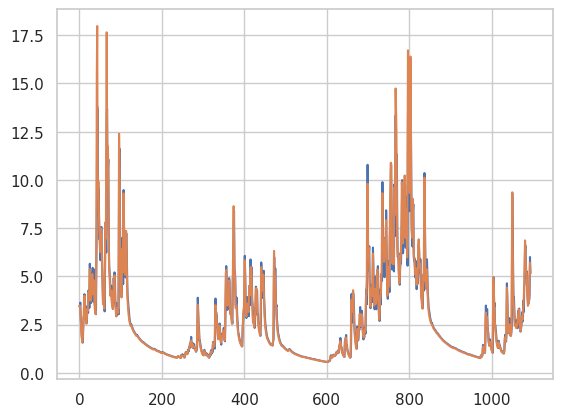

In [100]:
plt.plot(val_results)

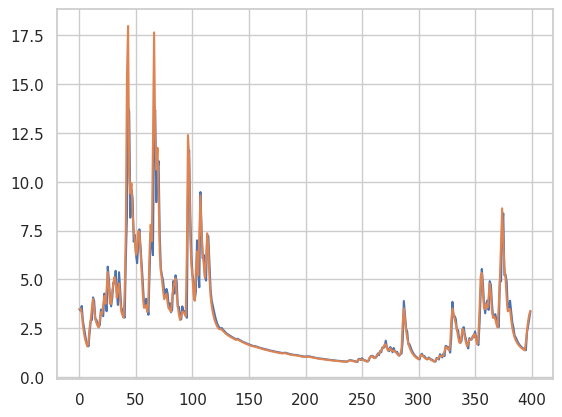

In [101]:
plt.plot(val_results['Val Predictions'][:400])
plt.plot(val_results['Actuals'][:400])

In [102]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
print(test_results)
print(len(test_results))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
     Test Predictions   Actuals
0            4.742556  4.992233
1            5.137358  5.708850
2            5.999965  7.692498
3            8.537410  8.573268
4            7.534548  7.179813
..                ...       ...
445          3.397295  3.233367
446          3.270229  4.948635
447          6.783087  6.703302
448          5.991233  5.398925
449          4.509728  4.334335

[450 rows x 2 columns]
450


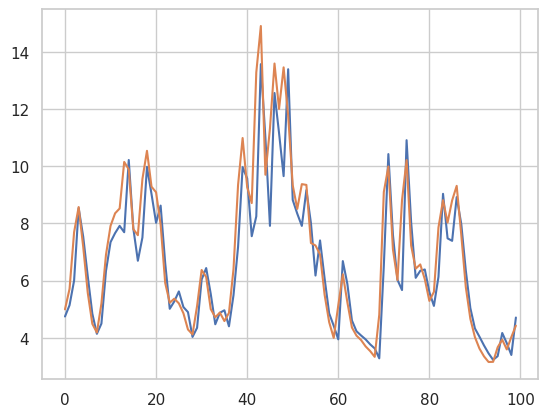

In [103]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [104]:
# Calculate the start index for validation and test sets
val_start_idx = WINDOW_SIZE + len(X_train1)
test_start_idx = val_start_idx + len(X_val1)

# Extract the corresponding date indices for validation and test datasets
val_dates = df.index[val_start_idx:val_start_idx + len(val_predictions)]
test_dates = df.index[test_start_idx:test_start_idx + len(test_predictions)]

# Create DataFrames that include the dates
val_results = pd.DataFrame({
    'Date': val_dates,
    'Val Predictions': val_predictions,
    'Actuals': y_val1
}).set_index('Date')

test_results = pd.DataFrame({
    'Date': test_dates,
    'Test Predictions': test_predictions,
    'Actuals': y_test1
}).set_index('Date')

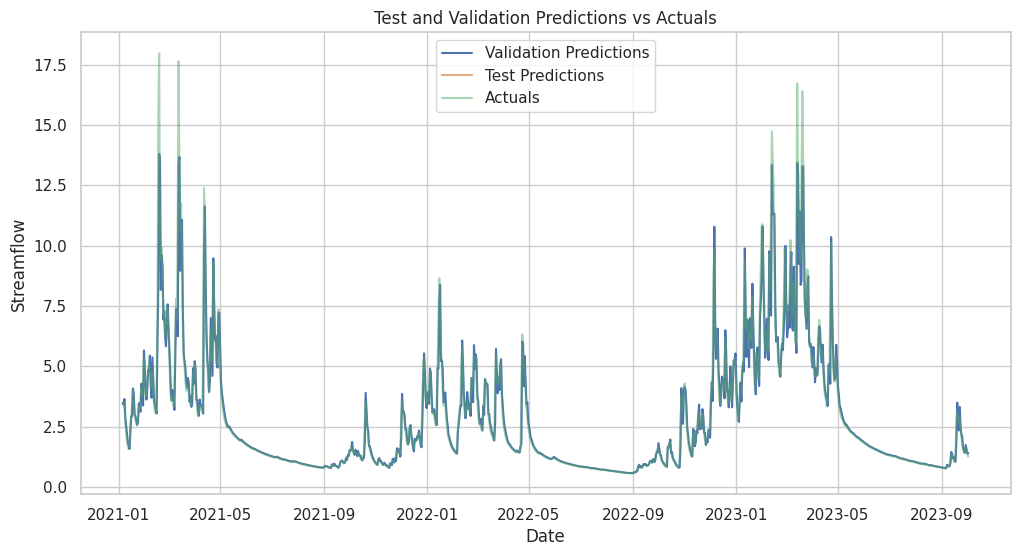

In [105]:
# Calculate the start index for validation and test sets
val_start_idx = WINDOW_SIZE + len(X_train1)
test_start_idx = val_start_idx + len(X_val1)

# Extract the corresponding date indices for validation and test datasets
val_dates = df.index[val_start_idx:val_start_idx + len(X_val1)]
test_dates = df.index[test_start_idx:test_start_idx + len(X_test1)]

# Create DataFrames that include the dates
val_results = pd.DataFrame({
    'Date': val_dates,
    'Val Predictions': val_predictions,
    'Actuals': y_val1
}).set_index('Date')

test_results = pd.DataFrame({
    'Date': test_dates,
    'Test Predictions': test_predictions,
    'Actuals': y_test1
}).set_index('Date')

# Combine validation and test results into one DataFrame for plotting
evaluation_results = pd.concat([val_results, test_results])

# Plot for test results
plt.figure(figsize=(12, 6))
plt.plot(evaluation_results.index[:1000], evaluation_results['Val Predictions'][:1000], label='Validation Predictions')
plt.plot(evaluation_results.index[:1000], evaluation_results['Test Predictions'][:1000], label='Test Predictions', alpha=0.7)
plt.plot(evaluation_results.index[:1000], evaluation_results['Actuals'][:1000], label='Actuals', alpha=0.5)
plt.title('Test and Validation Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.legend()
plt.show()

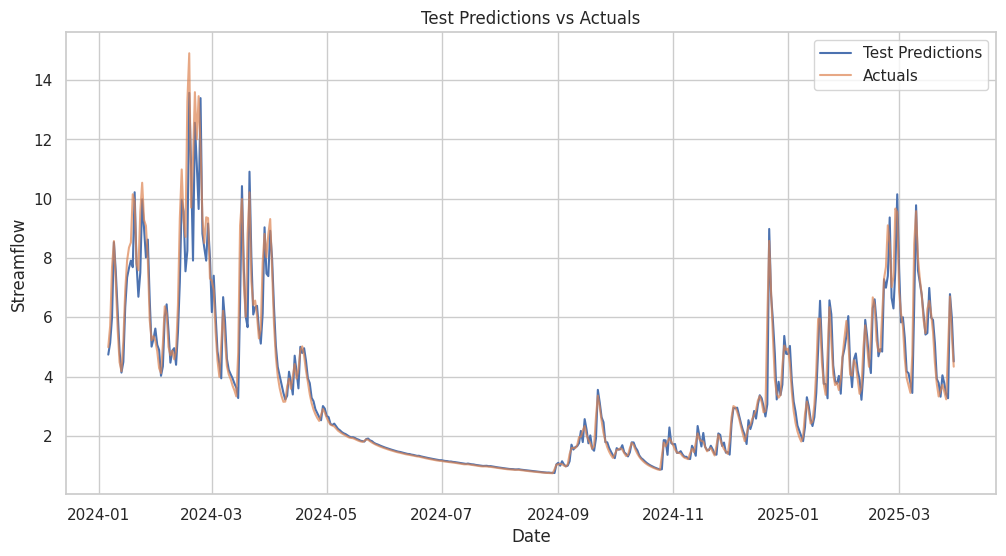

In [106]:
# Plot for test results
plt.figure(figsize=(12, 6))
plt.plot(test_results['Test Predictions'][:1000], label='Test Predictions')
plt.plot(test_results['Actuals'][:1000], label='Actuals', alpha=0.7)
plt.title('Test Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.legend()
plt.show()


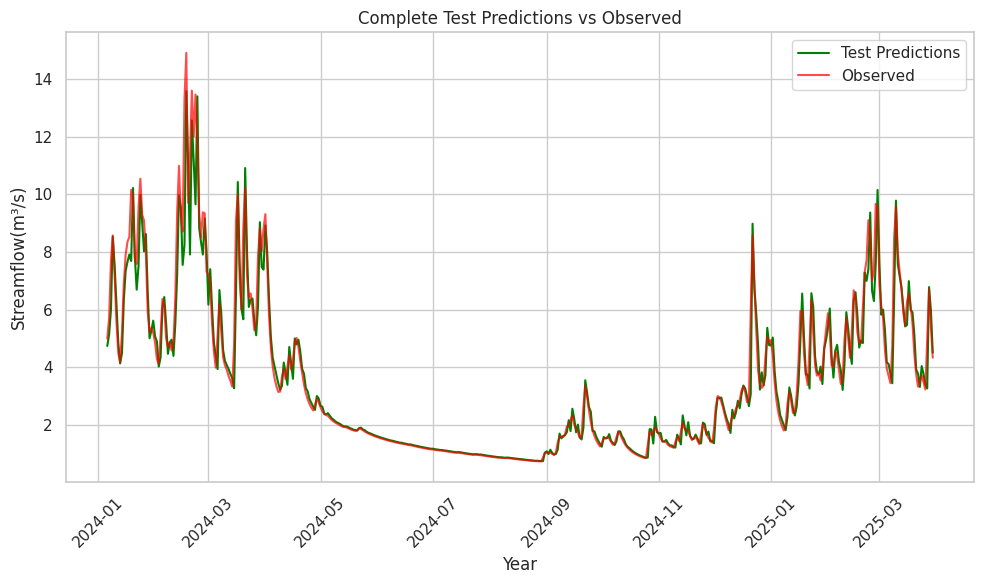

In [107]:
# Plot for complete test results
plt.figure(figsize=(10, 6))
plt.plot(test_results['Test Predictions'], label='Test Predictions', color='green')
plt.plot(test_results['Actuals'], label='Observed', color='red', alpha=0.7)
plt.title('Complete Test Predictions vs Observed')
plt.xlabel('Year')
plt.ylabel('Streamflow(m³/s)')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility if necessary
plt.tight_layout()  # Adjust layout to make room for date labels
plt.show()

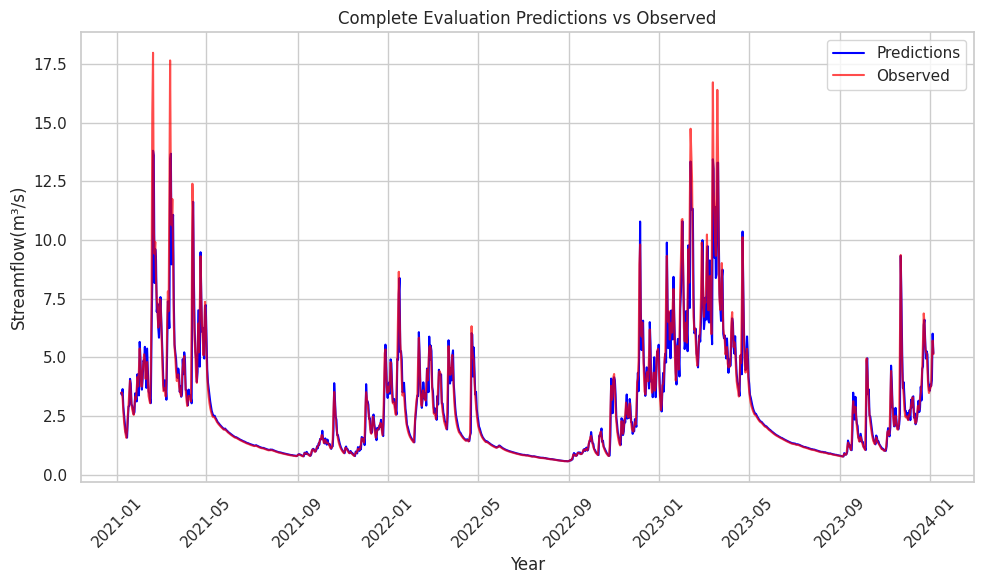

In [108]:
import matplotlib.pyplot as plt

# Plot for complete validation results
plt.figure(figsize=(10, 6))
plt.plot(val_results['Val Predictions'], label='Predictions', color='blue')
plt.plot(val_results['Actuals'], label='Observed', color='red', alpha=0.7)
plt.title('Complete Evaluation Predictions vs Observed')
plt.xlabel('Year')
plt.ylabel('Streamflow(m³/s)')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility if necessary
plt.tight_layout()  # Adjust layout to make room for date labels
plt.show()

In [109]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [110]:
def calculate_nse(actuals, predictions):
    """
    Nash-Sutcliffe Efficiency
    """
    return 1 - (np.sum((predictions - actuals) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))

def calculate_pbias(actuals, predictions):
    """
    Percent Bias
    """
    return 100.0 * (np.sum(predictions - actuals) / np.sum(actuals))

def calculate_rmse(actuals, predictions):
    """
    Root Mean Squared Error
    """
    return np.sqrt(mean_squared_error(actuals, predictions))

def calculate_mae(actuals, predictions):
    """
    Mean Absolute Error
    """
    return mean_absolute_error(actuals, predictions)

def calculate_r2(actuals, predictions):
    """
    Coefficient of Determination (R^2)
    """
    return r2_score(actuals, predictions)


In [111]:
# Assuming val_results DataFrame with columns 'Val Predictions' and 'Actuals'
actuals_val = val_results['Actuals']
predictions_val = val_results['Val Predictions']

# Calculate metrics
nse_val = calculate_nse(actuals_val, predictions_val)
pbias_val = calculate_pbias(actuals_val, predictions_val)
rmse_val = calculate_rmse(actuals_val, predictions_val)
mae_val = calculate_mae(actuals_val, predictions_val)
r2_val = calculate_r2(actuals_val, predictions_val)

# Print the results
print("Evaluation Metrics:")
print("Nash-Sutcliffe Efficiency (NSE):", nse_val)
#print("Percent Bias (PBIAS):", pbias_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("Mean Absolute Error (MAE):", mae_val)
print("Coefficient of Determination (R^2):", r2_val)

Evaluation Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.9339581089781954
Root Mean Squared Error (RMSE): 0.6535154982192732
Mean Absolute Error (MAE): 0.2769290588125081
Coefficient of Determination (R^2): 0.9339581089781954


In [112]:
# Print the results
print("Evaluation Metrics:")
print("Nash-Sutcliffe Efficiency (NSE): {:.2f}".format(nse_val))
#print("Percent Bias (PBIAS): {:.2f}".format(pbias_val))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_val))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_val))
print("Coefficient of Determination (R^2): {:.2f}".format(r2_val))

Evaluation Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.93
Root Mean Squared Error (RMSE): 0.65
Mean Absolute Error (MAE): 0.28
Coefficient of Determination (R^2): 0.93


In [113]:
# Assuming test_results DataFrame with columns 'Test Predictions' and 'Actuals'
actuals_test = test_results['Actuals']
predictions_test = test_results['Test Predictions']

# Calculate metrics
nse_test = calculate_nse(actuals_test, predictions_test)
pbias_test = calculate_pbias(actuals_test, predictions_test)
rmse_test = calculate_rmse(actuals_test, predictions_test)
mae_test = calculate_mae(actuals_test, predictions_test)
r2_test = calculate_r2(actuals_test, predictions_test)

# Print the results
print("Test Metrics:")
print("Nash-Sutcliffe Efficiency (NSE):", nse_test)
#print("Percent Bias (PBIAS):", pbias_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("Mean Absolute Error (MAE):", mae_test)
print("Coefficient of Determination (R^2):", r2_test)

Test Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.9483781384372948
Root Mean Squared Error (RMSE): 0.6267524366779912
Mean Absolute Error (MAE): 0.3209421231229655
Coefficient of Determination (R^2): 0.9483781384372948


In [114]:
# Print the results with two decimal places
print("Test Metrics:")
print("Nash-Sutcliffe Efficiency (NSE): {:.2f}".format(nse_test))
#print("Percent Bias (PBIAS): {:.2f}".format(pbias_test))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_test))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_test))
print("Coefficient of Determination (R^2): {:.2f}".format(r2_test))

Test Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.95
Root Mean Squared Error (RMSE): 0.63
Mean Absolute Error (MAE): 0.32
Coefficient of Determination (R^2): 0.95


In [115]:
# Predictions for validation set
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame({'Val Predictions': val_predictions, 'Actuals': y_val1})

# Predictions for test set
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame({'Test Predictions': test_predictions, 'Actuals': y_test1})

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlation
def plot_correlation(data, x, y, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, data=data)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    # Adding a line of best fit
    sns.regplot(x=x, y=y, data=data, scatter=False)
    plt.show()

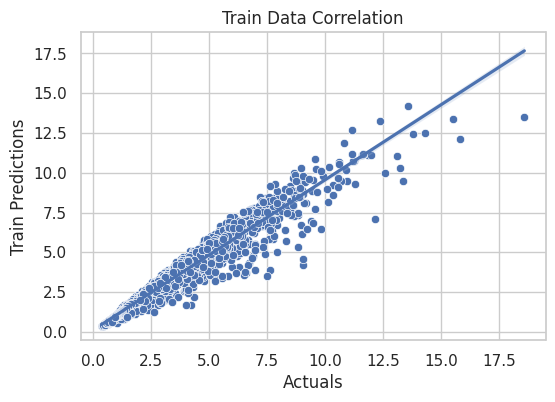

In [117]:
# Plot correlations for Train, Validation, and Test sets
plot_correlation(train_results, 'Actuals', 'Train Predictions', 'Train Data Correlation')

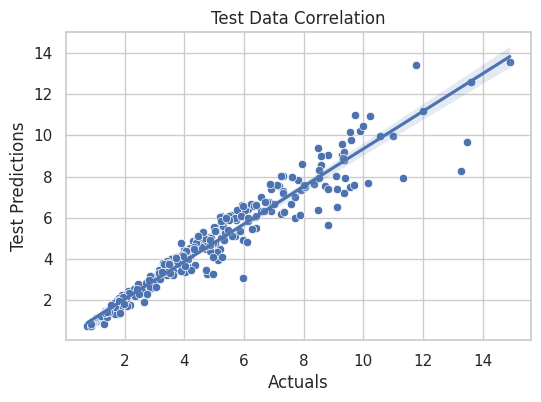

In [118]:
plot_correlation(test_results, 'Actuals', 'Test Predictions', 'Test Data Correlation')

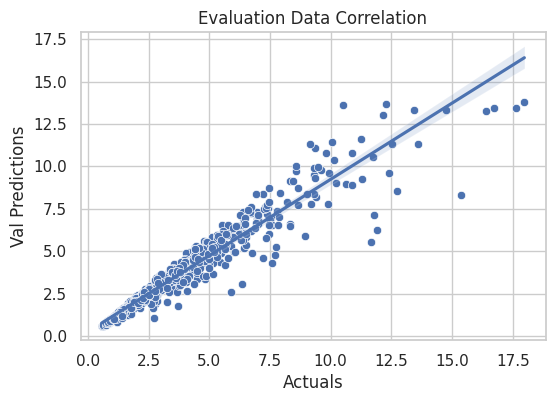

In [119]:
plot_correlation(val_results, 'Actuals', 'Val Predictions', 'Evaluation Data Correlation')

In [120]:
val_predictions = model1.predict(X_val1).flatten()
test_predictions = model1.predict(X_test1).flatten()

val_results = pd.DataFrame({'Val Predictions': val_predictions, 'Actuals': y_val1})
test_results = pd.DataFrame({'Test Predictions': test_predictions, 'Actuals': y_test1})


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipython-input-121-3689606047.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


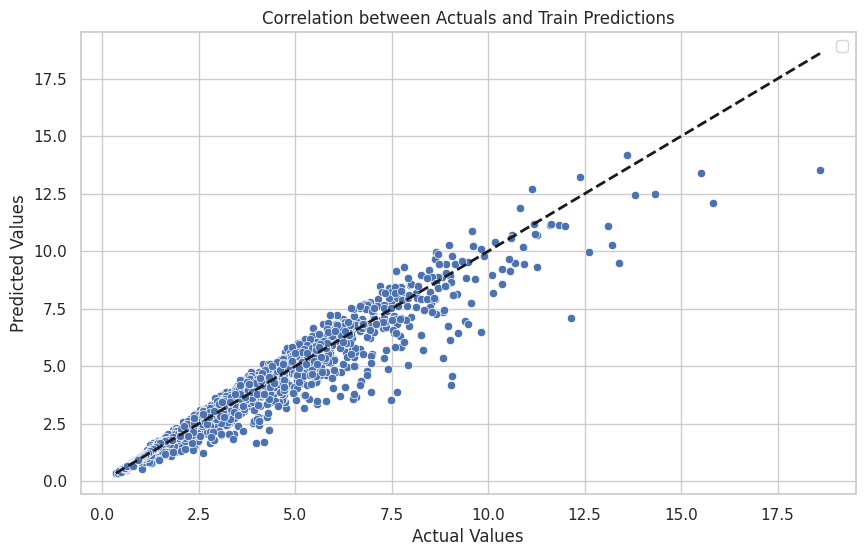

In [121]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Training data plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_results['Actuals'], y=train_results['Train Predictions'])
plt.plot([train_results['Actuals'].min(), train_results['Actuals'].max()], [train_results['Actuals'].min(), train_results['Actuals'].max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Correlation between Actuals and Train Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

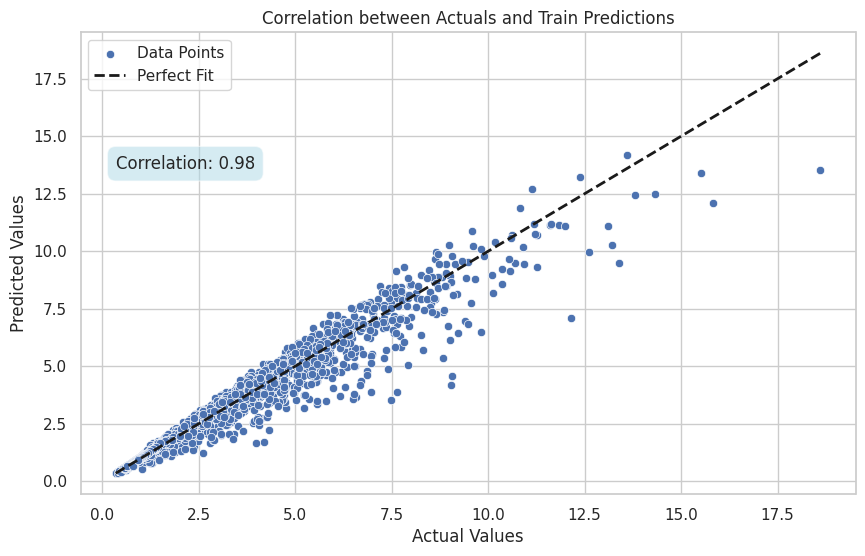

In [122]:
plt.figure(figsize=(10, 6))

# Plotting the scatter plot
sns.scatterplot(x=train_results['Actuals'], y=train_results['Train Predictions'], label='Data Points')

# Adding a diagonal reference line
plt.plot([train_results['Actuals'].min(), train_results['Actuals'].max()],
         [train_results['Actuals'].min(), train_results['Actuals'].max()],
         'k--', lw=2, label='Perfect Fit')

# Title and labels
plt.title('Correlation between Actuals and Train Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Calculate and display the correlation coefficient
corr_coef = np.corrcoef(train_results['Actuals'], train_results['Train Predictions'])[0, 1]
plt.text(x=min(train_results['Actuals']), y=max(train_results['Train Predictions']),
         s=f'Correlation: {corr_coef:.2f}',
         fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.5))

# Show legend
plt.legend()

# Display the plot
plt.show()

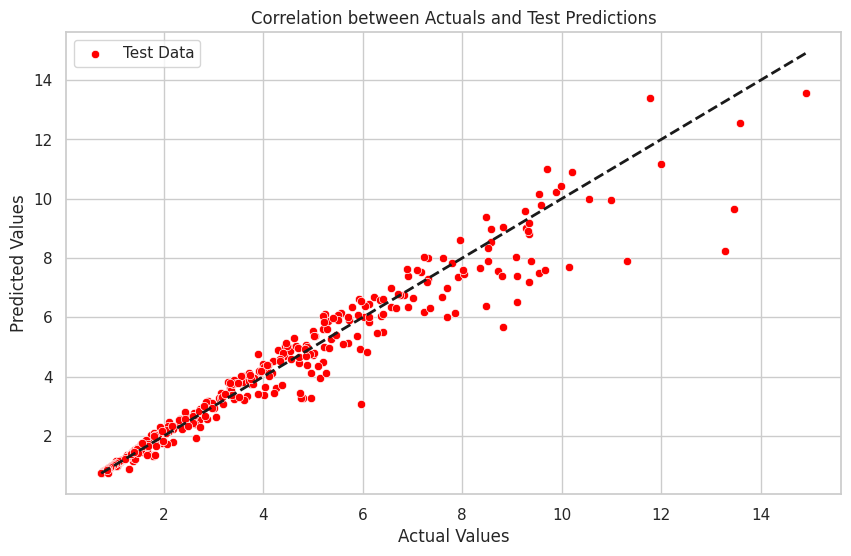

In [123]:
# Test data plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_results['Actuals'], y=test_results['Test Predictions'], color='red', label='Test Data')
plt.plot([test_results['Actuals'].min(), test_results['Actuals'].max()], [test_results['Actuals'].min(), test_results['Actuals'].max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Correlation between Actuals and Test Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

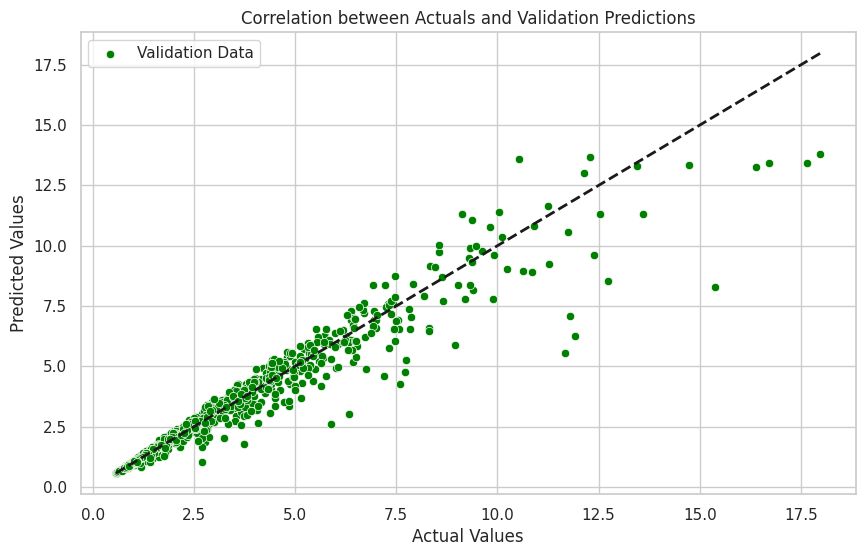

In [124]:

# Validation data plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_results['Actuals'], y=val_results['Val Predictions'], color='green', label='Validation Data')
plt.plot([val_results['Actuals'].min(), val_results['Actuals'].max()], [val_results['Actuals'].min(), val_results['Actuals'].max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Correlation between Actuals and Validation Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


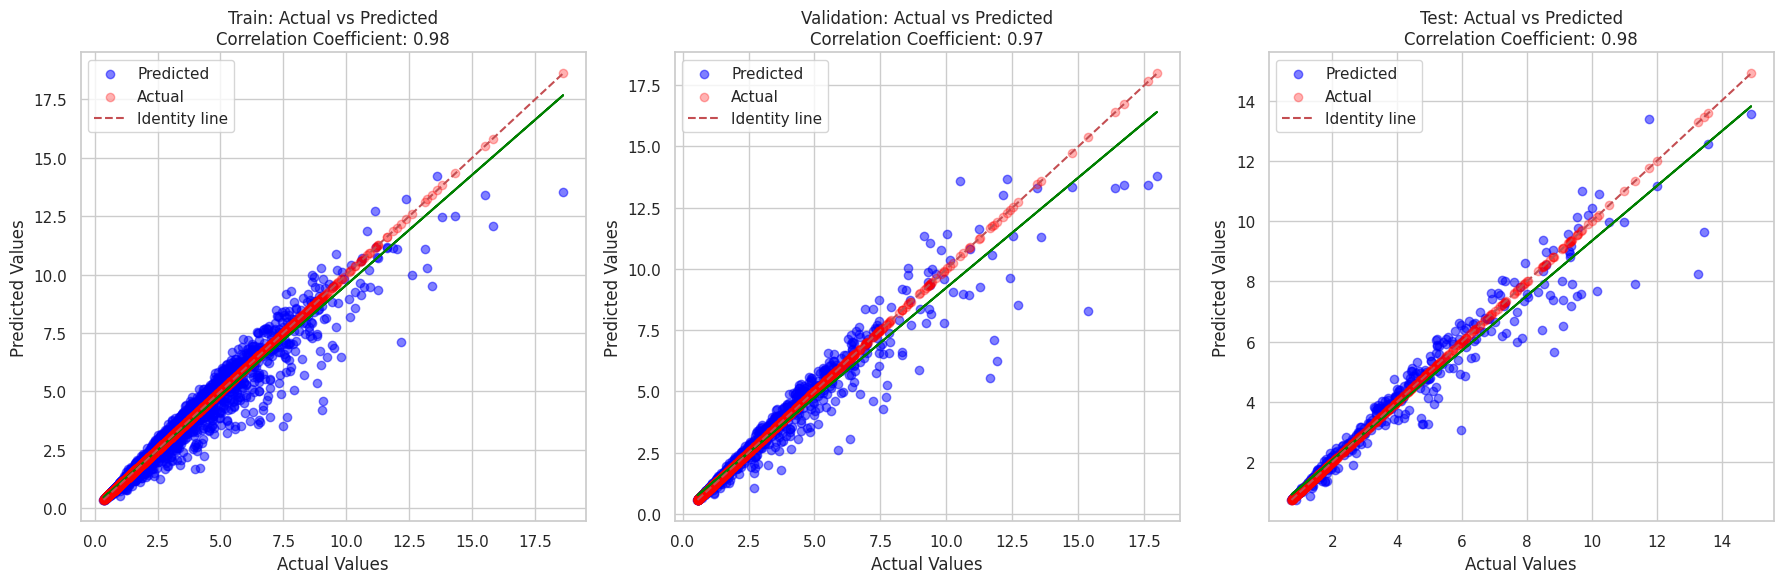

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the matplotlib figure
plt.figure(figsize=(18, 6))

# Define a function to plot correlation
def plot_correlation(ax, actuals, predictions, title):
    # Scatter plot
    ax.scatter(actuals, predictions, color='blue', alpha=0.5, label='Predicted')
    ax.scatter(actuals, actuals, color='red', alpha=0.3, label='Actual')

    # Fit line (best fit for predicted)
    m, b = np.polyfit(actuals, predictions, 1)
    ax.plot(actuals, m*actuals + b, color='green')

    # Correlation coefficient
    corr_coef = np.corrcoef(actuals, predictions)[0, 1]

    # Plotting the identity line
    ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', label='Identity line')

    # Set titles and labels
    ax.set_title(f'{title}\nCorrelation Coefficient: {corr_coef:.2f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

    # Add legend
    ax.legend()

# Training Data Plot
ax1 = plt.subplot(1, 3, 1)
plot_correlation(ax1, train_results['Actuals'], train_results['Train Predictions'], 'Train: Actual vs Predicted')

# Validation Data Plot
ax2 = plt.subplot(1, 3, 2)
plot_correlation(ax2, val_results['Actuals'], val_results['Val Predictions'], 'Validation: Actual vs Predicted')

# Test Data Plot
ax3 = plt.subplot(1, 3, 3)
plot_correlation(ax3, test_results['Actuals'], test_results['Test Predictions'], 'Test: Actual vs Predicted')

# Display the plot
plt.tight_layout()
plt.show()


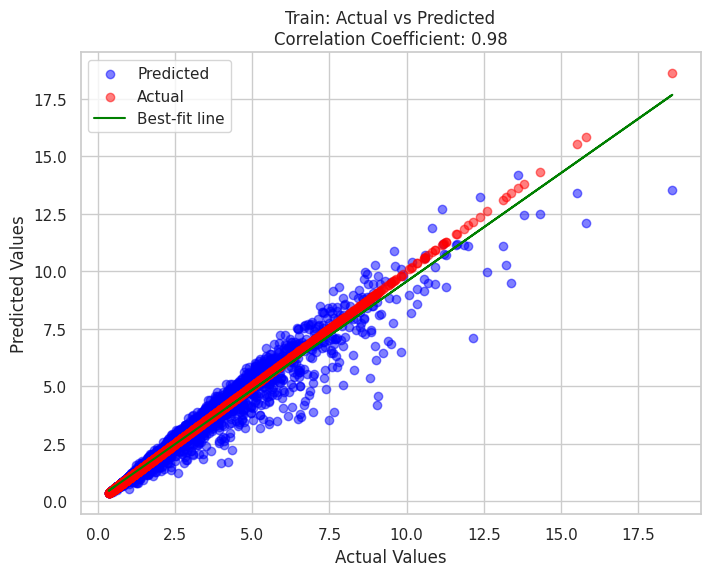

In [126]:

import matplotlib.pyplot as plt
import numpy as np

def plot_correlation(ax, actuals, predictions, title):
    # Scatter plot for predictions
    ax.scatter(actuals, predictions, color='blue', alpha=0.5, label='Predicted')
    # Scatter plot for actuals (overlaid for comparison)
    ax.scatter(actuals, actuals, color='red', alpha=0.5, label='Actual')

    # Fit line (best fit for predictions)
    m, b = np.polyfit(actuals, predictions, 1)
    ax.plot(actuals, m*actuals + b, color='green', label='Best-fit line')

    # Correlation coefficient
    corr_coef = np.corrcoef(actuals, predictions)[0, 1]

    # Identity line (shows perfect prediction)
    #ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', label='Identity line')

    # Setting titles and labels
    ax.set_title(f'{title}\nCorrelation Coefficient: {corr_coef:.2f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

    # Add legend to the plot
    ax.legend()
# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# Training Data Plot
plot_correlation(ax1, train_results['Actuals'], train_results['Train Predictions'], 'Train: Actual vs Predicted')

# Display the plot
plt.show()

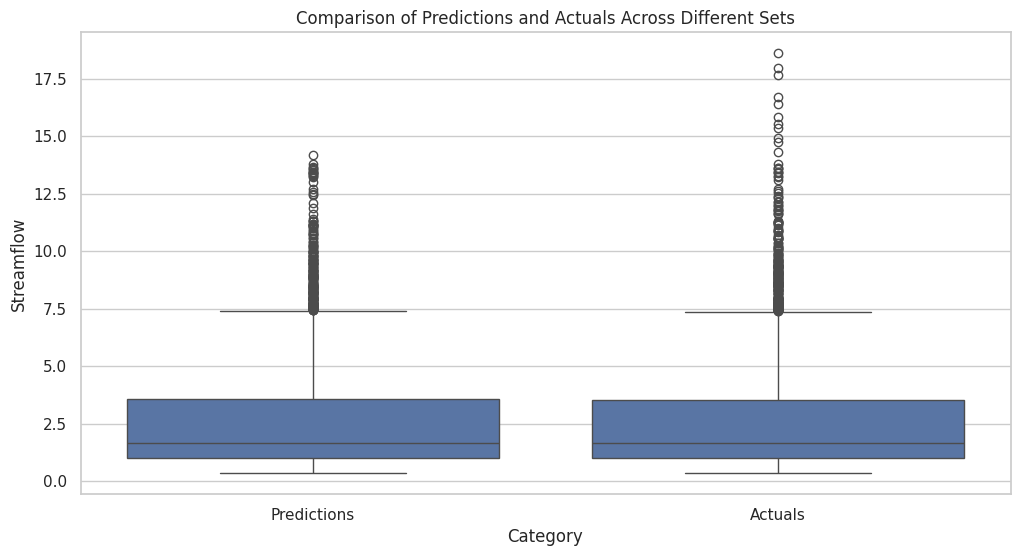

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Importing seaborn for enhanced visualization

# Combining results from train, validation, and test datasets
# Each dataset's predictions are renamed to a common column name for uniformity
combined_results = pd.concat([
    train_results.rename(columns={'Train Predictions': 'Predictions'})[['Predictions', 'Actuals']],
    val_results.rename(columns={'Val Predictions': 'Predictions'})[['Predictions', 'Actuals']],
    test_results.rename(columns={'Test Predictions': 'Predictions'})[['Predictions', 'Actuals']]
], ignore_index=True)  # Ensure a new index is set for the combined DataFrame

# Reshape the DataFrame for suitable plotting using 'melt'
# This changes the DataFrame format from wide to long
melted_results = pd.melt(combined_results, value_vars=['Predictions', 'Actuals'])

# Plotting the data using seaborn's boxplot for better style and visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='variable', y='value', data=melted_results)
plt.title('Comparison of Predictions and Actuals Across Different Sets')
plt.xlabel('Category')
plt.ylabel('Streamflow')
plt.show()
